In [64]:
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, uniform, skew, kurtosis
from sklearn.metrics import r2_score
import statsmodels.api as sm
import os
from arch.univariate import ConstantMean, GARCH, Normal
from arch.__future__ import reindexing
from arch.univariate import arch_model
from arch import arch_model
from arch.univariate import GARCH
from arch.__future__ import reindexing
import yfinance as yf

# Question 1: Conduct Lasso Regression

Conduct LASSO regression of Macro Variables (X) to forecast one month ahead market returns (Y). Select the optimal penalty according to 10-fold cross-validation. What is the preferred model in this approach? What is the predictive performance of your model as a function of the penalty parameter? What variables get selected with non-zero coefficients? Interpret your findings.

In [81]:
df_2010 = pd.read_excel("C:/jibrile/Downloads/current_copy.xlsx")
df_2010.rename(columns={'sasdate': 'Date'}, inplace=True)

In [82]:
df_2010 = df_2010.set_index('Date')

In [83]:
df_2010.columns

Index(['vwretd', 'RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx_transformed',
       'RETAILx_transformed', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD',
       ...
       'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008',
       'CES3000000008', 'UMCSENTx_transformed', 'DTCOLNVHFNM', 'DTCTHFNM',
       'INVEST', 'VIXCLSx_transformed'],
      dtype='object', length=128)

In [84]:
df_2010 = df_2010.iloc[1:, :]
df_2010.index = pd.to_datetime(df_2010.index, format="%Y%m%d")
df_2010_columns = list(df_2010.columns.values)

for col in df_2010_columns[1:]:
    df_2010[col] = (df_2010[col] - df_2010[col].mean()) / df_2010[col].std()

In [85]:
columns_to_remove = ["ACOGNO", "ANDENOx_transformed", "TWEXAFEGSMTHx"]
df_2010.drop(columns = columns_to_remove, inplace = True)

In [94]:
df_2010 = df_2010.iloc[:617]

In [96]:
import pandas as pd
from sklearn.linear_model import LassoCV

X = df_2010.drop('S&P 500_transformed', axis=1).fillna(0)
y = df_2010['S&P 500_transformed'].fillna(0)

lasso_cv = LassoCV(cv=10, random_state=0)
lasso_cv.fit(X, y)

optimal_penalty = lasso_cv.alpha_

In [97]:
print(f"The optimal penalty is {optimal_penalty}")
mean_square_errors = np.mean(lasso_cv.mse_path_, axis=1)

print("")

print("preffered model coefficients:")
print(lasso_cv.coef_)

The optimal penalty is 0.021954768900457545

preffered model coefficients:
[-0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.         -0.
  0.88582964 -0.08618692  0.00382455 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0

**The predictive performance of the model as a function of the penalty parameter is** 

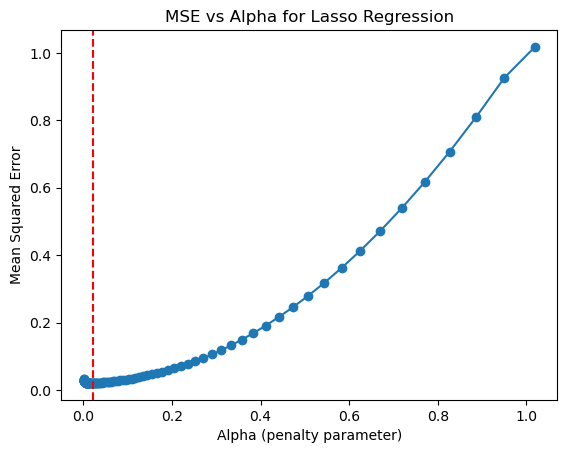

In [98]:
plt.plot(lasso_cv.alphas_, mean_square_errors, '-o')
plt.axvline(x=optimal_penalty, color='red', linestyle='--', label='Optimal Alpha')
plt.xlabel('Alpha (penalty parameter)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for Lasso Regression')
plt.show()

#

**The variables with non-zero coefficients are**

In [99]:
feature_names = X.columns.tolist()

# Variables selected by Lasso with non-zero coefficients
selected_variables = [feature_names[i] for i in range(len(lasso_cv.coef_)) if lasso_cv.coef_[i] != 0]

print(selected_variables)

['S&P: indust_transformed', 'S&P div yield_transformed', 'S&P PE ratio_transformed', 'VIXCLSx_transformed']


Interpretation of findings: 
- a
- b


# Question 2: Forecast Returns using principal components X.

Forecast returns using 1 to 5 principal components X. Construct a table with a column
for each model specification, and rows that report predictive coefficients, t-stats, and
R2
. Interpret your findings

In [104]:
# 1. compute covariance matrix
C = X.cov()

# 2. compute eigenvector and eigenvalues of covariance matrix
import numpy as np
eigenvalues, eigenvector = np.linalg.eig(C)

# 3. sort eigenvalues and eigenvectors in descending order, reorder the corresponding eigenvectors to match. 
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvector[:, sorted_indices]

# 4. select principal components
first_5_eigenvectors = sorted_eigenvectors[:, :5]

# 5. project original data onto the first 5 principal components to get new features and regress 
X_projected = np.dot(X, first_5_eigenvectors)

regression_model = LinearRegression()
regression_model.fit(X_projected, y)

LinearRegression()

In [105]:
# regress and get coefficients of components
def linear_regression(X, y):
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefficients

coefficients = linear_regression(X_projected, y)
coefficients

array([-0.00331835,  0.00123685, -0.02369139, -0.02245825, -0.10006738,
       -0.30668777])

**Construct table with each model specification and rows that report predictive coefficients, t-stats and R squared.**

In [106]:
original_variable_names = X.columns
original_variable_names = X.columns

# Mapping each principal component to its most influential original variables
for i, eigenvector in enumerate(first_5_eigenvectors.T):
    print(f"Principal Component {i+1}:")
    for variable, contribution in zip(original_variable_names, eigenvector):
        print(f"   {variable}: {contribution}")
    print("\n")

Principal Component 1:
   vwretd: 5.917485688639712e-05
   RPI: -0.10986065599675802
   W875RX1: -0.11431722191026175
   DPCERA3M086SBEA: -0.11282696770884236
   CMRMTSPLx_transformed: -0.00632485992559455
   RETAILx_transformed: -0.009890328056458439
   INDPRO: -0.1358966603544569
   IPFPNSS: -0.14840597616812468
   IPFINAL: -0.14610482862698193
   IPCONGD: -0.1544876960953291
   IPDCONGD: -0.1370346345481888
   IPNCONGD: -0.15976902093600928
   IPBUSEQ: -0.12642459546691562
   IPMAT: -0.12061195154121516
   IPDMAT: -0.1123220812391829
   IPNMAT: -0.15790078133084365
   IPMANSICS: -0.14130208785796236
   IPB51222S: -0.14036471478832302
   IPFUELS: -0.11589531593939109
   CUMFNS: 0.0835907046779013
   HWI_transformed: -0.002757971496024494
   HWIURATIO_transformed: -0.00339326816059548
   CLF16OV: -0.1399116276168839
   CE16OV: -0.13872992211641388
   UNRATE: -0.015779014050412193
   UEMPMEAN: -0.05204648257661514
   UEMPLT5: -0.07726048963728192
   UEMP5TO14: -0.08809170641032057
   U

In [107]:
def regression_analysis(X, y):
    """Perform linear regression and return coefficients, t-stats, and R-squared."""
    # Adding intercept term
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    # Calculating coefficients
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    # Predictions
    y_pred = X @ coefficients
    # Residuals
    residuals = y - y_pred
    # Mean Squared Error
    mse = np.sum(residuals**2) / (X.shape[0] - X.shape[1])
    # Standard error
    se = np.sqrt(np.diagonal(mse * np.linalg.inv(X.T @ X)))
    # t-statistics
    t_stats = coefficients / se
    # R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return coefficients, t_stats, r_squared

# Collecting results in a list
results = []

# Perform analysis for each principal component
for i in range(1, 6):  # Assuming we are using 5 principal components
    X_pc = X_projected[:, :i]  # Selecting first i principal components
    coefficients, t_stats, r_squared = regression_analysis(X_pc, y)

    # Collecting results for each model
    for j in range(i):
        results.append({
            'Model': f'Model with {i} PC(s)',
            'Coefficient': coefficients[j+1],  # Ignoring the intercept
            't-Statistic': t_stats[j+1],  # Ignoring the t-stat of intercept
            'R-squared': r_squared
        })

# Creating DataFrame from results
results_df = pd.DataFrame(results)

In [108]:
results_df

,Model,Coefficient,t-Statistic,R-squared
0,Model with 1 PC(s),0.001237,0.190650,0.000059
1,Model with 2 PC(s),0.001237,0.191150,0.006902
2,Model with 2 PC(s),-0.023691,-2.056861,0.006902
3,Model with 3 PC(s),0.001237,0.191424,0.011354
4,Model with 3 PC(s),-0.023691,-2.059807,0.011354
5,Model with 3 PC(s),-0.022458,-1.661389,0.011354
6,Model with 4 PC(s),0.001237,0.197103,0.069024
7,Model with 4 PC(s),-0.023691,-2.120914,0.069024
8,Model with 4 PC(s),-0.022458,-1.710677,0.069024
9,Model with 4 PC(s),-0.100067,-6.157187,0.069024


interpretation: 
- Model with 1 PC: This model explains a very small portion of the variance in the dependent variable (R-squared is close to 0). The coefficient is positive but not statistically significant (t-statistic is much less than 2).

- Model with 2 PCs: Adding the second PC increases the R-squared value slightly, indicating a marginally better fit. The second PC has a negative coefficient with a t-statistic suggesting statistical significance.

- Models with 3 to 5 PCs: As more PCs are added, the R-squared values increase, indicating better model fit. However, not all added PCs are statistically significant. For instance, in the model with 5 PCs, the last principal component (PC5) has a large negative coefficient and a high t-statistic, indicating a significant inverse relationship with the dependent variable and strong explanatory power.



# Question 6: Out of Sample forecasts on data beggining in jan 2011

In [110]:
cross-validated LASSO model: 

SyntaxError: invalid syntax (1104855840.py, line 1)